# State Transition - only states

In [16]:
import numpy as np
import os
from libraries.utils import *
from libraries.state_transition import StateTransition as st
import pandas as pd
from collections import defaultdict


## Load Data

In [17]:
############ configuration ################
############################################

CODE = 'lora_ducy'       ### application (code) theft_protection, mamba2, lora_ducy
BEHAVIOUR_FAULTY = 'faulty_data'            ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'            ### normal, faulty_data
THREAD = 'single'           ### single, multi
VER = 3                     ### format of data collection

base_dir = '../trace_data' ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print(normalbase_path)
print(faultybase_path)


../trace_data/lora_ducy/single_thread/version_3/normal
../trace_data/lora_ducy/single_thread/version_3/faulty_data


In [18]:

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = os.listdir(normalbase_path)
train_varlist_path = [os.path.join(normalbase_path, x) for x in train_varlist_path if 'varlist' in x]

######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

### remove.Ds_store from all lists
train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]

paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

print(train_data_path)
print(paths_log)
print(paths_traces)
print(varlist_path)
print(paths_label)

test_data_path = paths_traces
test_label_path = paths_label


['../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial1', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial6', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial8', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial9', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial7', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial12', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial5', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial2', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial3', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial11', '../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial10']
[]
['../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial1', '../trace_data

In [19]:
############# check varlist is consistent ############
############# only for version 3 ######################

if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]]+ varlist_path) ### compare with train varlist

    if check_con != False:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        ### load normal varlist
        print('loading normal varlist')
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)



varlist 1 is consistent with varlist 0
varlist 2 is consistent with varlist 0
varlist 3 is consistent with varlist 0
varlist 4 is consistent with varlist 0
varlist 5 is consistent with varlist 0
varlist 6 is consistent with varlist 0


In [27]:
#### length of train data
total_length = 0
for data in train_data_path:
    print(data)
    df = read_traces(data)
    length = len(df)
    total_length += int(length)

print('total length of train data:', total_length)

../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial1
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial6
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial8
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial9
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial7
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial12
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial5
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial2
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial3
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial11
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial10
total length of train data: 14362


In [5]:
############ Get variable list ######################
sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]   ### get the variable list
# print(var_list)

In [6]:
print(train_data_path[0])
print(train_data_path[0].find('.npy'))
print(train_data_path[0].find('.json') )

if train_data_path[0].find('.npy') != -1:
    sample_data = load_sample(train_data_path[0])
    print('.npy')
elif train_data_path[0].find('.json') != -1:
    sample_data = read_traces(train_data_path[0])
    print('.json')
else:
    sample_data = read_traces(train_data_path[0])
    print('no extension')

../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial1
-1
-1
no extension


## Training

In [7]:
### initialize
model = st()
model.train(train_data_path)

../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial1
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial6
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial8
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial9
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial7
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial12
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial5
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial2
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial3
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial11
../trace_data/lora_ducy/single_thread/version_3/normal/train_data/trace_trial10


In [8]:
transitions = model.transitions
transitions

defaultdict(list,
            {0: [1, 38, 57, 77, 61, 76, 84, 25],
             1: [2],
             2: [3],
             3: [4],
             4: [5],
             5: [6],
             6: [7],
             7: [8],
             8: [9],
             9: [10],
             10: [11],
             11: [12],
             12: [13],
             13: [14],
             14: [15],
             15: [16],
             16: [17],
             17: [18],
             18: [19],
             19: [20],
             20: [21],
             21: [22, 34],
             22: [23, 74, 69],
             23: [24, 28, 83, 0],
             24: [25, 67],
             25: [26, 74],
             26: [27, 23],
             27: [28, 68],
             28: [29, 0, 56],
             29: [30],
             30: [31, 74],
             31: [32, 74],
             32: [33],
             33: [34],
             34: [35, 68, 61],
             35: [36],
             36: [37],
             37: [38, 21],
             38: [39, 23, 0, 79, 

In [9]:
### viz transitions

for key in transitions.keys():
    print(from_number[key], ':', end=' ')
    for val in transitions[key]:
        print(from_number[val], end=', ')
    print('\n')

0-0-0-lora : 0-0-0-s, 0-0-0-cca_list, 0-0-cca-c, 0-0-0-noise_found, 0-0-0-send_time, 0-0-0-insatnce, 0-0-0-ss, 0-0-0-saved_transmissions, 

0-0-0-s : 0-0-0-wlan, 

0-0-0-wlan : 0-0-0-bluetooth, 

0-0-0-bluetooth : 0-0-get_node_id-node_id, 

0-0-get_node_id-node_id : 0-0-0-my_number, 

0-0-0-my_number : 0-0-0-source_address, 

0-0-0-source_address : 0-0-0-number_of_neighbours, 

0-0-0-number_of_neighbours : 0-0-0-chrono, 

0-0-0-chrono : 0-0-0-chrono1, 

0-0-0-chrono1 : 0-0-0-chrono2, 

0-0-0-chrono2 : 0-0-0-chrono3, 

0-0-0-chrono3 : 0-0-0-wakeup_interval, 

0-0-0-wakeup_interval : 0-0-0-fast_sleep_threshold, 

0-0-0-fast_sleep_threshold : 0-0-0-transmission_type, 

0-0-0-transmission_type : 0-0-0-num_of_packets, 

0-0-0-num_of_packets : 0-0-0-pll_threshold, 

0-0-0-pll_threshold : 0-0-0-cca_duration, 

0-0-0-cca_duration : 0-0-0-cca_interval, 

0-0-0-cca_interval : 0-0-0-rssi_threshold, 

0-0-0-rssi_threshold : 0-0-0-packet_size, 

0-0-0-packet_size : 0-0-0-packet_number, 

0-0-0-pack

## Validation

In [10]:
DIFF_VAL = 5
#### Validate model
all_detections = []  ### format [file1_detection, file2_detection] -> file1_detection: [(state1, state2), (ts1, ts2), filename]
y_pred_all = []
y_true_all = []
all_tp = []
all_fp = []
all_fn = []
all_gt = []

# tp = 0
# fp = 0
# fn = 0

for test_data, test_label in zip(test_data_path, test_label_path):
    detection = model.test_single(test_data)
    all_detections += [(test_data, detection, test_label)]  ### used to plot detections
    print('Detections:', detection)
    print('len of detections:', len(detection))

    merged_detection, grouped_det = model.merge_detections(detection, DIFF_VAL)  ### merge detections for multiple variables
    detection = merged_detection


    ground_truth_raw = read_traces(test_label)
    ground_truth = ground_truth_raw['labels']
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]
    print('ground truths:', ground_truth)
    print(len(ground_truth))

    correct_pred, rest_pred, y_pred, y_true, false_neg = model.get_correct_detections(detection, ground_truth)

    y_pred_all.extend(y_pred)
    y_true_all.extend(y_true)
    all_tp += [(test_data, correct_pred, test_label)]
    all_fp += [(test_data, rest_pred, test_label)]
    all_fn += [(test_data, false_neg, test_label)]
    all_gt += [(test_data, ground_truth, test_label)]


    # tp, fp, tn, fn = model.calculate_tp_fp_tn_fn(detection, ground_truth)

    # tp+=tp
    # fp+=fp
    # fn+=fn
    


# result = model.test(test_data_path)

{0: [1, 38, 57, 77, 61, 76, 84, 25], 1: [2], 2: [3], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8], 8: [9], 9: [10], 10: [11], 11: [12], 12: [13], 13: [14], 14: [15], 15: [16], 16: [17], 17: [18], 18: [19], 19: [20], 20: [21], 21: [22, 34], 22: [23, 74, 69], 23: [24, 28, 83, 0], 24: [25, 67], 25: [26, 74], 26: [27, 23], 27: [28, 68], 28: [29, 0, 56], 29: [30], 30: [31, 74], 31: [32, 74], 32: [33], 33: [34], 34: [35, 68, 61], 35: [36], 36: [37], 37: [38, 21], 38: [39, 23, 0, 79, 64], 39: [40], 40: [41, 82], 41: [42], 42: [43, 37, 26], 43: [44], 44: [45], 45: [46], 46: [47], 47: [48], 48: [49], 49: [50], 50: [51, 55], 51: [52], 52: [53], 53: [51, 54], 54: [50, 56, 65, 51], 55: [54], 56: [57, 0], 57: [58, 59, 27, 70], 58: [57], 59: [60, 56], 60: [56], 77: [78], 78: [38], 79: [74, 30], 74: [80, 75], 80: [75], 75: [81, 23, 61, 41], 81: [40, 23], 82: [23], 83: [28], 61: [62, 70, 26, 23, 24, 41], 62: [63], 63: [38], 64: [65, 54, 31], 65: [66], 66: [67], 67: [34, 0], 68: [69, 23], 69: [70, 0, 74, 24,

In [11]:
print('y_pred', y_pred_all)
print('y_true', y_true_all)
print(len(y_true_all))


y_pred [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
y_true [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
20


In [12]:
all_fn

[('../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial1',
  [[1195, 1205, 458239, 478436, 5],
   [1392, 1405, 516972, 519467, 5],
   [1597, 1605, 556293, 575932, 5]],
  '../trace_data/lora_ducy/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json'),
 ('../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial2',
  [[702, 712, 260252, 280452, 5]],
  '../trace_data/lora_ducy/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json'),
 ('../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial3',
  [[434, 454, 81248, 101440, 5],
   [654, 674, 159332, 178973, 5],
   [1114, 1134, 319304, 338317, 5],
   [1594, 1614, 497307, 517240, 5]],
  '../trace_data/lora_ducy/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json')]

In [13]:
print('all_fp:', all_fp)
fp_count = 0
for fp in all_fp:
    print( len(fp[1]))
    fp_count += len(fp[1])

print('fp_count:', fp_count)

all_fp: [('../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial1', [[(22, 22), (457312, 457315), 'trace_trial1'], [(22, 22), (497367, 497370), 'trace_trial1'], [(22, 22), (556288, 556290), 'trace_trial1']], '../trace_data/lora_ducy/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json'), ('../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial2', [[(22, 22), (259338, 259340), 'trace_trial2']], '../trace_data/lora_ducy/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json'), ('../trace_data/lora_ducy/single_thread/version_3/faulty_data/trace_trial3', [[(22, 22), (80330, 80332), 'trace_trial3'], [(22, 22), (159327, 159329), 'trace_trial3'], [(22, 22), (318395, 318397), 'trace_trial3'], [(22, 22), (496395, 496398), 'trace_trial3']], '../trace_data/lora_ducy/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json')]
3
1
4
fp_count: 8


Precision: 0.3333
Recall: 0.3333
F1 Score: 0.3333
Confusion Matrix:
[[0 8]
 [8 4]]
#################################################


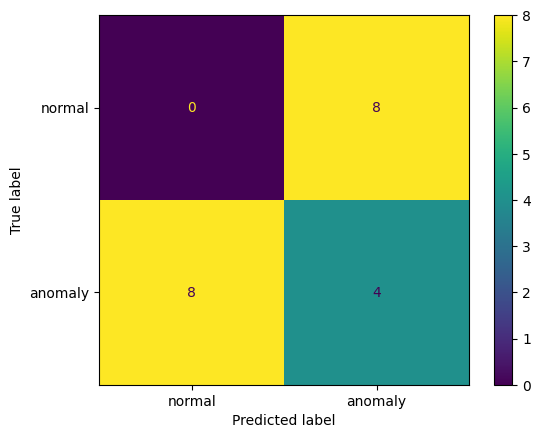

In [14]:
### Evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, average_precision_score, ConfusionMatrixDisplay


# Calculate precision
precision = precision_score(y_true_all, y_pred_all)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_true_all, y_pred_all)
print(f'Recall: {recall:.4f}')

# # Calculate average precision
# average_precision = average_precision_score(y_true_all, y_pred_all)
# print(f'Average Precision: {average_precision:.4f}')

# Calculate F1 score
f1 = f1_score(y_true_all, y_pred_all)
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:")
print(conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['normal', 'anomaly'])
disp.plot()



print('#################################################')

# # Initialize counters
# TP = tp
# FP = fp
# TN = tn
# FN = fn

# # Calculate precision and recall
# precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# recall = TP / (TP + FN) if (TP + FN) > 0 else 0
# # Calculate F1 Score
# f1s = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0



# # Print results
# print(f"True Positives: {TP}")
# print(f"False Positives: {FP}")
# print(f"True Negatives: {TN}")
# print(f"False Negatives: {FN}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1s:.2f}")


## Classwise Detections

In [27]:
classwise_fn = defaultdict(list)
classwise_tp = defaultdict(list)
gt_len = 0
for file_fn, file_gt in zip(all_fn, all_gt):
    fn = file_fn[1]
    gt = file_gt[1]
    for label in gt:
        if label in fn:
            classwise_fn[label[4]].append(label)
        else:
            classwise_tp[label[4]].append(label)
            # print('tp:', label)

    gt_len += len(gt)
    # print('file gt:', len(gt))
    # print('file fn:', len(fn))
    # print('\n')
    # break

total_fn = 0
total_tp = 0
keys = set(list(classwise_fn.keys()) + list(classwise_tp.keys()))
# print('keys:', keys)
for key in keys:
    print('class:', key)
    total_fn += len(classwise_fn[key])
    total_tp += len(classwise_tp[key])

    # print('not detected:', len(classwise_fn[key]))
    print('detected:', len(classwise_tp[key]))
    print('total anomalies:', len(classwise_fn[key])+len(classwise_tp[key]))
    print('\n')


# print('total fn+tp:', total_fn+total_tp)
# print('total gt:', gt_len)
assert total_fn+total_tp == gt_len, 'total fn+tp not equal to total gt'

class: 5
detected: 4
total anomalies: 12




## Save Detections

In [28]:
######## save detections for the dashboard to plot #############
import traceback

# DIFF_VAL = 0

for test_data, detections, test_label in all_detections:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', f'st_detections')
    detection_path = detection_path.replace('st_detections.json', f'st_detections_{DIFF_VAL}.json')
    # tp_detection_path = detection_path.replace('ei_detections.json', f'tp_ei_detections_{DIFF_VAL}.json')
    # fp_detection_path = detection_path.replace('ei_detections.json', f'fp_ei_detections_{DIFF_VAL}.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:
        with open(detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {detection_path}')

            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_tp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'st_detections')
    tp_detection_path = detection_path.replace('st_detections.json', f'tp_st_detections_{DIFF_VAL}.json')
    # fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(tp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {tp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_fp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'st_detections')
    # tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
    fp_detection_path = detection_path.replace('st_detections.json', f'fp_st_detections_{DIFF_VAL}.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(fp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {fp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial1_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial2_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial3_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial1_tp_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial2_tp_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial3_tp_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detections/trace_trial1_fp_st_detections_5.json
Saved detections in ../trace_data/lora_ducy/single_thread/version_3/faulty_data/st_detection

## Plot Detections

In [17]:
# ### plot gt and detections
# for test_data, detections, test_label_path in all_detections:
# # for test_data, detections, test_label_path in all_tp:
#     print('test_data:', test_data)
#     print('detections:', detections)

#     ### prepare trace to plot
#     col_data = preprocess_traces([test_data])
#     all_df = get_dataframe(col_data) 
#     # print(all_df[0])

#     ### prepare detections to plot
#     timestamps = col_data[0][1]
#     print('timestamps:', timestamps)
#     plot_val = []
#     plot_x_ticks = []
#     plot_class = []
#     for det in detections:
#         print(det)
#         det_ts1, det_ts2 = det[1]
#         print(det_ts1, det_ts2)

#         det_ind1_pre = [ abs(t-det_ts1) for t in timestamps]
#         det_ind1 = det_ind1_pre.index(min(det_ind1_pre))

#         det_ind2_pre = [ abs(t-det_ts2) for t in timestamps]
#         det_ind2 = det_ind2_pre.index(min(det_ind2_pre))
#         # print(det_ind1, det_ind2)
#         # print(timestamps[det_ind1], timestamps[det_ind2])

#         plot_val += [(det_ind1, det_ind2)]
#         plot_x_ticks += [(timestamps[det_ind1], timestamps[det_ind2])]
#         plot_class += [0]

#     plot_detections = [plot_val, plot_x_ticks, plot_class]

#     ### get ground truths
#     gt_plot = prepare_gt(test_label_path)

#     ### plot
#     for df in all_df:
#         # print(df.columns)
#         plot_fig = plot_single_trace(df, 
#                           var_list, 
#                           with_time=False, 
#                           is_xticks=True, 
#                           detections=plot_detections, 
#                           dt_classlist=['detection'],
#                           ground_truths=gt_plot,
#                           gt_classlist=['gt_communication', 'gt_sensor', 'gt_bitflip'],
#                           )
#         plot_fig.show()

#     # break

### generate transition table

In [18]:
# import pandas as pd
# from pptx import Presentation
# from pptx.util import Inches
# from pptx.util import Pt
# from pptx.util import Inches
# from pptx.dml.color import RGBColor

# # Create a DataFrame from the dictionary
# df = pd.DataFrame(list(transitions.items()), columns=['Key', 'Values'])

# # Combine values for each key into a single cell
# df_combined = df.groupby('Key')['Values'].agg(lambda x: ', '.join(map(str, x))).reset_index()

# # Create a PowerPoint presentation
# presentation = Presentation()

# # Add a slide to the presentation
# slide_layout = presentation.slide_layouts[5]  # Using a blank slide layout
# slide = presentation.slides.add_slide(slide_layout)

# # Define the position and size of the table
# left = Inches(1)
# top = Inches(1)
# width = Inches(6)
# height = Inches(4)

# # Add a table shape to the slide
# table = slide.shapes.add_table(rows=df_combined.shape[0] + 1, cols=df_combined.shape[1], left=left, top=top, width=width, height=height).table

# # Add column names to the first row
# for col, col_name in enumerate(df_combined.columns):
#     cell = table.cell(0, col)
#     cell.text = col_name
#     cell.text_frame.text = col_name
#     cell.text_frame.paragraphs[0].font.size = Pt(10)
#     cell.text_frame.paragraphs[0].font.bold = True
#     cell.fill.solid()
#     cell.fill.fore_color.rgb = RGBColor(240, 240, 240)  # Light gray background color

# # Add data to the table
# for row in range(df_combined.shape[0]):
#     for col in range(df_combined.shape[1]):
#         cell = table.cell(row + 1, col)
#         cell.text = str(df_combined.iloc[row, col])
#         cell.text_frame.text = str(df_combined.iloc[row, col])
#         cell.text_frame.paragraphs[0].font.size = Pt(10)

# # Save the PowerPoint presentation
# presentation.save('table_presentation.pptx')



In [ ]:
6200 + (9910-6500) + 8260 + (1100-8260) + 

17870